In [1]:
import pvl
import struct
import matplotlib.pyplot as plt
import numpy as np
import datetime
import os.path
import binascii

In [2]:
crism_file = '/home/arsanders/testData/crism/tsts/trdr/input/frt0001e5c3_07_if124s_trr3.lbl'
image_file = crism_file

In [3]:
header = pvl.load(crism_file)

In [4]:
header

PVLModule([
  ('PDS_VERSION_ID', 'PDS3')
  ('LABEL_REVISION_NOTE',
   '2004-11-22, S. Slavney (GEO); 2005-12-20, H. Taylor (JHU/APL); 2006-04-05, '
   'S. Murchie (JHU/APL); 2006-09-18, P. Cavender (JHU/APL); 2007-02-19, P. '
   'Cavender (JHU/APL); Version 2, new stray light subtraction 2010-06-01, D. '
   'Humm (JHU/APL); Version 3, shutter mirror correction 2010-10-12, C. Hash '
   '(ACT); Version 3, Added data filter control parameters')
  ('DATA_SET_ID', 'MRO-M-CRISM-3-RDR-TARGETED-V1.0')
  ('PRODUCT_ID', 'FRT0001E5C3_07_IF124S_TRR3')
  ('INSTRUMENT_HOST_NAME', 'MARS RECONNAISSANCE ORBITER')
  ('SPACECRAFT_ID', 'MRO')
  ('INSTRUMENT_NAME', 'COMPACT RECONNAISSANCE IMAGING SPECTROMETER FOR MARS')
  ('INSTRUMENT_ID', 'CRISM')
  ('TARGET_NAME', 'MARS')
  ('PRODUCT_TYPE', 'TARGETED_RDR')
  ('PRODUCT_CREATION_TIME',
   datetime.datetime(2011, 6, 8, 10, 52, 30, tzinfo=datetime.timezone.utc))
  ('START_TIME',
   datetime.datetime(2011, 6, 2, 4, 3, 9, 29000, tzinfo=datetime.timezone.utc))


In [5]:
with open(crism_file, 'rb') as f:
    image_file = os.path.dirname(crism_file) + "/" + header['FILE']["^IMAGE"].lower()
    with open(image_file, 'rb') as im_f:
        b_image_data = im_f.read()

In [6]:
n_lines = 1
line_length = header['FILE']['IMAGE']['LINE_SAMPLES'] * (header['FILE']['IMAGE']['SAMPLE_BITS']//8)

In [7]:
def read_crism_trdr(b_image_data, line_length, n_lines, n_bands):
    image_data = []
    for j in range(n_lines*n_bands):
        image_sample = np.frombuffer(b_image_data[j*line_length:(j+1)*line_length],
                                     dtype=np.float32, count=int(line_length/4))
        image_data.append(image_sample)
    return np.array(image_data)

In [8]:
#
n_output_bands = 107
n_bands = header['FILE']['IMAGE']['BANDS']
image_data = read_crism_trdr(b_image_data, line_length, n_lines, n_bands)

cropped_image_data = image_data

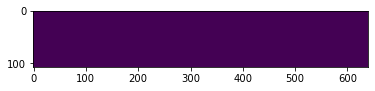

In [9]:
plt.imshow(cropped_image_data)

In [10]:
image_fn, image_ext = os.path.splitext(image_file)
mini_image_fn = image_fn + '_cropped' + image_ext
mini_image_bn = os.path.basename(mini_image_fn)

# Overwrite the number of lines in the label
header['FILE']['IMAGE']['LINES'] = n_lines
header['FILE']['IMAGE']['BANDS'] = n_output_bands
header['FILE']['^IMAGE'] = mini_image_bn
header['FILE']['FILE_RECORDS'] = n_lines * n_output_bands + 1
header['FILE']['^ROWNUM_TABLE'][0] = mini_image_bn
header['FILE']['^ROWNUM_TABLE'][1] = n_lines * n_output_bands + 1
header['FILE']['ROWNUM_TABLE']['ROWS'] = n_output_bands
# Access the second instance of "FILE", which can't be accessed by name
header[-1][1]['TRDR_HK_TABLE'] = 0
header[-1][1]['^TRDR_HK_TABLE'] = 0

In [12]:
label_fn, label_ext = os.path.splitext(crism_file)
out_label = label_fn + '_cropped' + label_ext

grammar = pvl.grammar.ISISGrammar()
grammar.comments+=(("#", "\n"), )
encoder = pvl.encoder.ISISEncoder()
pvl.dump(header, out_label, encoder=encoder, grammar=grammar)

6596

In [13]:
with open(mini_image_fn, 'wb+') as f:
    b_reduced_image_data = cropped_image_data.tobytes()
    f.seek(0, 2)
    f.write(b_reduced_image_data)